# DC2 Coadd Run1.1p GCR access

__Purpose__: This tutorial will illustrate the basics of accessing the merged coadd catalogs through the Generic Catalog Reader (GCR, https://github.com/yymao/generic-catalog-reader) as well as how to select useful samples of stars/galaxies from the DM outputs.


Note: This notebook is intended to be run through the JupyterHub NERSC interface available here: https://jupyter-dev.nersc.gov. To setup your NERSC environment, please follow the instructions available here: https://confluence.slac.stanford.edu/display/LSSTDESC/Using+Jupyter-dev+at+NERSC

In [3]:
import GCRCatalogs
from GCR import GCRQuery
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Accessing the coadd catalog with the GCR

The [GCRCatalogs](https://github.com/LSSTDESC/gcr-catalogs) package is a DESC project which aims at gathering in one convenient location various simulation/data catalogs made available to the collaboration.  
In this section, we illustrate how to use this tool to access the coadd catalogs from DC2 Run1.1p.

In [16]:
import GCRCatalogs
# Load the coadd catalog
catalog = GCRCatalogs.load_catalog('dc2_coadd_run1.1p')

A significant numbers of catalogs besides the DC2 coadd are already available, use `sorted(GCRCatalogs.get_available_catalogs(False))` to see a full list and visit the [DC2 Data Product](https://confluence.slac.stanford.edu/display/LSSTDESC/DC2+Data+Product+Overview) page to see all the DC2 related catalogs.

### DC2 Coadd catalog Schema


To see the quantities available in the catalog, you can use the following:

In [ ]:
sorted(catalog.list_all_quantities())

The meaning of these fields is documented in the [SCHEMA.md](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-dc2-coadd-catalogs) file of the `gcr-catalog` repository.  
As explained in that link, the values exposed here are not the native quantities produced by the Data Management stack, but instead this schema strives to follow the standard nomenclature of the LSST Data Products Definition Document [DPDD](http://ls.st/dpdd).

The DPDD is an effort made by the LSST project to standardize the format of the official Data Release Products (DRP). While the native outputs of the DM stack are succeptible to change, the DPDD will be more stable. An early adoption of these conventions by the DESC will save time and energy down the road.

This being said, not all use-cases and relevant quantities are covered by these conventions yet, so the GCR preserves access to the underlying native DM stack fieds, all 2046 of which can be listed using:  

In [ ]:
sorted(catalog.list_all_native_quantities())

==TODO== : Quickly go through the most important fields ?

### Accessing the data

While run1.1p is still of manageable size, full DC2 will be much larger, accessing the whole data can be challenging. In order to access the data efficiently, it is important to understand how it is physically stored and how to access it, one piece at the time. 


The coadds produced by the DM stack are structured in terms of large `tracts` and smaller `patches`, illustrated here for DC2:
<img src="assets/dc2_skymap.png">
Here the tracts have large blue numbers, and the patches are denoted with an `(x,y)` format. For DC2, each tract has 8x8 patches.

The GCR coadd catalog preserves this structure of the data so that any particular quantity can be accessed on a tract/patch bases. The tracts available in the catalog can be listed using the following command:

In [21]:
# Query all available tracts and patches, only displays the first 5
catalog.available_tracts_and_patches[:5]

[{'tract': 4430, 'patch': '0,1'},
 {'tract': 4430, 'patch': '0,2'},
 {'tract': 4430, 'patch': '0,3'},
 {'tract': 4430, 'patch': '0,4'},
 {'tract': 4430, 'patch': '0,5'}]

In [ ]:



### Catalog schema

The LSST project is making an effort to standardize the format of the Data Release Products (which include source and object catalogs) documented here: http://ls.st/dpdd. Note that this is on top of the native format of the Data Management stack outputs which can change with time, an early adoption of this standard schema 

- Explain the idea of native quantities and DPDD compliant fields
- Show how to access native fields if necessary
- Quickly go through the most important fields
- Explain how to return data as pandas DF


- Explain how the data is structured in terms of tract/patches
- Show how to load catalog
- Query the tracts and patches
- Apply native filters (needs knowledge of how the data is actually stored) and native iterators

In [4]:
catalog = GCRCatalogs.load_catalog('dc2_coadd_run1.1p')

In [3]:
sorted(catalog.list_all_quantities())

['I_flag',
 'I_flag_g',
 'I_flag_i',
 'I_flag_r',
 'I_flag_u',
 'I_flag_y',
 'I_flag_z',
 'Ixx',
 'IxxPSF',
 'IxxPSF_g',
 'IxxPSF_i',
 'IxxPSF_r',
 'IxxPSF_u',
 'IxxPSF_y',
 'IxxPSF_z',
 'Ixx_g',
 'Ixx_i',
 'Ixx_r',
 'Ixx_u',
 'Ixx_y',
 'Ixx_z',
 'Ixy',
 'IxyPSF',
 'IxyPSF_g',
 'IxyPSF_i',
 'IxyPSF_r',
 'IxyPSF_u',
 'IxyPSF_y',
 'IxyPSF_z',
 'Ixy_g',
 'Ixy_i',
 'Ixy_r',
 'Ixy_u',
 'Ixy_y',
 'Ixy_z',
 'Iyy',
 'IyyPSF',
 'IyyPSF_g',
 'IyyPSF_i',
 'IyyPSF_r',
 'IyyPSF_u',
 'IyyPSF_y',
 'IyyPSF_z',
 'Iyy_g',
 'Iyy_i',
 'Iyy_r',
 'Iyy_u',
 'Iyy_y',
 'Iyy_z',
 'blendedness',
 'clean',
 'dec',
 'extendedness',
 'good',
 'mag_g',
 'mag_g_cModel',
 'mag_i',
 'mag_i_cModel',
 'mag_r',
 'mag_r_cModel',
 'mag_u',
 'mag_u_cModel',
 'mag_y',
 'mag_y_cModel',
 'mag_z',
 'mag_z_cModel',
 'magerr_g',
 'magerr_g_cModel',
 'magerr_i',
 'magerr_i_cModel',
 'magerr_r',
 'magerr_r_cModel',
 'magerr_u',
 'magerr_u_cModel',
 'magerr_y',
 'magerr_y_cModel',
 'magerr_z',
 'magerr_z_cModel',
 'objectId',
 'paren

In [4]:
sorted(catalog.list_all_native_quantities())

['base_Blendedness_abs_child_xx',
 'base_Blendedness_abs_child_xy',
 'base_Blendedness_abs_child_yy',
 'base_Blendedness_abs_flux',
 'base_Blendedness_abs_flux_child',
 'base_Blendedness_abs_flux_parent',
 'base_Blendedness_abs_parent_xx',
 'base_Blendedness_abs_parent_xy',
 'base_Blendedness_abs_parent_yy',
 'base_Blendedness_flag',
 'base_Blendedness_flag_noCentroid',
 'base_Blendedness_flag_noShape',
 'base_Blendedness_old',
 'base_Blendedness_raw_child_xx',
 'base_Blendedness_raw_child_xy',
 'base_Blendedness_raw_child_yy',
 'base_Blendedness_raw_flux',
 'base_Blendedness_raw_flux_child',
 'base_Blendedness_raw_flux_parent',
 'base_Blendedness_raw_parent_xx',
 'base_Blendedness_raw_parent_xy',
 'base_Blendedness_raw_parent_yy',
 'base_CircularApertureFlux_12_0_flag',
 'base_CircularApertureFlux_12_0_flag_apertureTruncated',
 'base_CircularApertureFlux_12_0_flux',
 'base_CircularApertureFlux_12_0_fluxSigma',
 'base_CircularApertureFlux_17_0_flag',
 'base_CircularApertureFlux_17_0_fl

<img src="https://hsc-release.mtk.nao.ac.jp/rsrc/wide_coverage/W-XMMLSS_g_area.png">

In [21]:
catalog.available_tracts_and_patches[:5]

[{'patch': '0,1', 'tract': 4430},
 {'patch': '0,2', 'tract': 4430},
 {'patch': '0,3', 'tract': 4430},
 {'patch': '0,4', 'tract': 4430},
 {'patch': '0,5', 'tract': 4430}]

In [19]:
%timeit qt = catalog.get_quantities(['ra', 'dec'], native_filters=[(lambda x: x==4430, 'tract')])

100 loops, best of 3: 17.2 ms per loop


In [20]:
%timeit qt = catalog.get_quantities(['ra', 'dec'])

The slowest run took 342.30 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 747 ms per loop


- Return data as dictionary, create pandas dataframe
- Return iterator

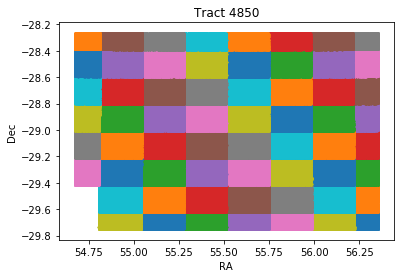

In [26]:
tract_number = 4850
for d in catalog.get_quantities(['ra', 'dec'], native_filters=[(lambda x: x==tract_number, 'tract')], return_iterator=True):
    plt.scatter(d['ra'], d['dec'], s=2);
plt.xlabel('RA');
plt.ylabel('Dec');
plt.title('Tract {}'.format(tract_number));

## Selection and filtering procedure
- Explain how to apply cuts with the GCR
- Show the effect of the `good` cut
- Show people how to select a sample of objects using the HSC `lensing` flag

## Example of filtering: Star/galaxy separation

For now, we have `extendedness == base_ClassificationExtendedness_value` as a tool for star/galaxy classification. An object is considered extended if the the difference between the `PSF` magnitude and the `CModel` magnitude is beyond certain threshold (0.0164). To know more about this see [Bosch et al. 2017](https://arxiv.org/pdf/1705.06766.pdf) section 4.9.10

In [ ]:
star_cuts = [
    GCRQuery((False, 'extendedness'))
]
quantities = ['mag_g_cModel','mag_r_cModel','mag_i_cModel']
d = catalog.get_quantities(quantities, 
                           filters=star_cuts, 
                           native_filters=[(lambda x: x==tract_number, 'tract')])

So now, we are selected what we think are stars. Let's take a look at the colors of these objects

In [ ]:
plt.hist2d(plt.hist2d(d['g_mag_CModel']-d['r_mag_CModel'],d['r_mag_CModel']-d['i_mag_CModel'],bins=100,range=[(-1,2),(-1,2)]);
plt.xlabel('$g-r$')
plt.ylabel('$r-i$'))

* Compare with the reference catalog or just show the plot with the comparison?

## Example of filtering: Lensing cuts

In [42]:
catalog.add_quantity_modifier('HSM_res', 
                              'ext_shapeHSM_HsmShapeRegauss_resolution', 
                              overwrite=True)
catalog.add_quantity_modifier('HSM_ell', 
                              (np.hypot, 'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2'), 
                              overwrite=True)

lensing_cuts = [
    ~GCRQuery((np.isnan, 'mag_i_cModel')), # (from this and below) remove nan entries
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_resolution')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e1')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e2')),
    GCRQuery('good'), 
    GCRQuery('snr_i_cModel >= 10'), # (from this and below) cut on object properties
    GCRQuery('HSM_res >= 0.3'),
    GCRQuery('HSM_ell < 2.0'),
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),
    GCRQuery('mag_i_cModel < 24.5'), # FIXME: Doesnt have exinction correction
    GCRQuery('blendedness < 10**(-0.375)'),
]

In [43]:
tract_number = 4850
quantities = ['mag_i_cModel']
d = catalog.get_quantities(quantities, 
                           filters=lensing_cuts, 
                           native_filters=[(lambda x: x==tract_number, 'tract')])

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:164: RuntimeWarning: divide by zero encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,
/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:164: RuntimeWarning: invalid value encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,


## Galaxy size and magnitudes compared to HSC 
- Mention the different types of size and magnitude measurments
- Comparison to HSC dataset

## Challenge: Galaxy counts-in-cells

Blending affects the accuracy of centroid and flux measurements. It can potentially generate a systematic effect in different measurements (for example 2-point statistics). 

The stack, returns a very useful value to check (partially) for the presence of these kind of systematics, which is the `blendedness` parameter (more details on Section 4.9.11 of [Bosch et al. 2017](https://arxiv.org/pdf/1705.06766.pdf)

* Q: Why partially?


A very simple tool to measure the different statistical moments of galaxies is Counts-in-cells (CiC) [Peebles et al. 1980](https://press.princeton.edu/titles/724.html). Here, we are going to use a simplified version of CiC to check the possible systematic effects due to differences in the `blendedness` measurements.

In [1]:
from cic import cic_analysis

In [2]:
import healpy as hp

In [ ]:
# Let's use almost the same cuts as in the WL sample
cic_cuts_nb = [
    ~GCRQuery((np.isnan, 'mag_i_cModel')), # (from this and below) remove nan entries
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_resolution')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e1')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e2')),
    GCRQuery('good'), 
    GCRQuery('snr_i_cModel >= 10'), # (from this and below) cut on object properties
    GCRQuery('HSM_res >= 0.3'),
    GCRQuery('HSM_ell < 2.0'),
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),
    GCRQuery('blendedness < 10**(-0.375)'),
]

cic_cuts_b = [
    ~GCRQuery((np.isnan, 'mag_i_cModel')), # (from this and below) remove nan entries
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_resolution')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e1')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e2')),
    GCRQuery('good'), 
    GCRQuery('snr_i_cModel >= 10'), # (from this and below) cut on object properties
    GCRQuery('HSM_res >= 0.3'),
    GCRQuery('HSM_ell < 2.0'),
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),
    GCRQuery('blendedness > 10**(-0.375)'),
]

quantities = ['ra','dec']
d_nb = catalog.get_quantities(quantities, 
                           filters=cic_cuts_nb, 
                           native_filters=[(lambda x: x==tract_number, 'tract')])
d_b = catalog.get_quantities(quantities, 
                           filters=cic_cuts_b, 
                           native_filters=[(lambda x: x==tract_number, 'tract')])

sigma_b, sigma_err_b, skw_b, skw_err_b, kurtosis_b, kurtosis_err_b, pixel_scale = cic_analysis(d_b)
sigma_nb, sigma_err_nb, skw_nb, skw_err_nb, kurtosis_nb, kurtosis_err_nb, _  = cic_analysis(d_nb)
#TODO: Include CiC with shapes?

In [ ]:
plt.errorbar(pixel_scale, sigma_b, sigma_err_b, fmt='o', linestyle='none', label='High blendedness')
plt.errorbar(pixel_scale, sigma_nb, sigma_err_nb, fmt='x', linestyle='none', label='Low blendedness')
plt.legend()
plt.xlabel('Pixel scale [deg]')
plt.ylabel(r'$\sigma$')

## Challenge: Check if PSF residuals are within requirements

- First explain how the DM stack models stars and PSF
- How to select a sample of good looking stars
- compute rho statistics in stile

In [5]:
catalog = GCRCatalogs.load_catalog('dc2_coadd_run1.1p')

In [6]:
#TODO: A few words about PSF modeling

In [5]:
# Adds modifiers to compute stars size and ellipticity
g1_modif = lambda ixx,iyy,ixy: (ixx-iyy)/(ixx+iyy)
g2_modif = lambda ixx,iyy,ixy:  2.*ixy/(ixx+iyy)
sigma_modif = lambda ixx,iyy,ixy: (ixx*iyy - ixy**2)**0.25

catalog.add_modifier_on_derived_quantities('g1', g1_modif, 'Ixx', 'Iyy', 'Ixy')
catalog.add_modifier_on_derived_quantities('g2', g2_modif, 'Ixx', 'Iyy', 'Ixy')
catalog.add_modifier_on_derived_quantities('sigma', sigma_modif, 'Ixx', 'Iyy', 'Ixy')

catalog.add_modifier_on_derived_quantities('psf_g1', g1_modif, 'IxxPSF', 'IyyPSF', 'IxyPSF')
catalog.add_modifier_on_derived_quantities('psf_g2', g2_modif, 'IxxPSF', 'IyyPSF', 'IxyPSF')
catalog.add_modifier_on_derived_quantities('psf_sigma', sigma_modif, 'IxxPSF', 'IyyPSF', 'IxyPSF')

In [6]:
# Extracting data selecting only point sources
data = catalog.get_quantities(['ra', 'dec', 'mag_i', 'i_SNR', 'psf_fwhm_i',
                               'g1', 'g2', 'sigma',
                               'psf_g1', 'psf_g2', 'psf_sigma'], 
                               # native_filters=[(lambda x: x==4850, 'tract')],
                                filters=[GCRQuery('good'), 
                                         GCRQuery('clean'), 
                                        ~GCRQuery('I_flag'),
                                        ~GCRQuery('base_SdssShape_flag_badCentroid'),
                                         GCRQuery('extendedness == 0'),
                                        ~GCRQuery((np.isnan, 'mag_i_cModel')), # (from this and below) remove nan entries
                                        ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_resolution')),
                                        ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e1')),
                                        ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e2')),
                                         GCRQuery('blendedness < 10**(-0.375)'),
                                         GCRQuery('mag_i < 21')])

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:164: RuntimeWarning: invalid value encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,
/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:164: RuntimeWarning: divide by zero encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,


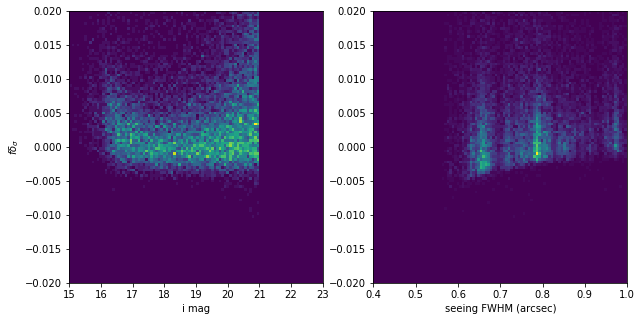

In [7]:
figure(figsize=(10,5))

subplot(121)
hist2d(data['mag_i'], (data['sigma'] - data['psf_sigma'])/data['psf_sigma'], 100, range=[[15,23],[-0.02,0.02]]);
xlabel('i mag')
ylabel('$f \delta_\sigma$')
subplot(122)
hist2d(data['psf_fwhm_i'], (data['sigma'] - data['psf_sigma'])/data['psf_sigma'], 100, range=[[0.4,1.0],[-0.02,0.02]]);
xlabel('seeing FWHM (arcsec)')

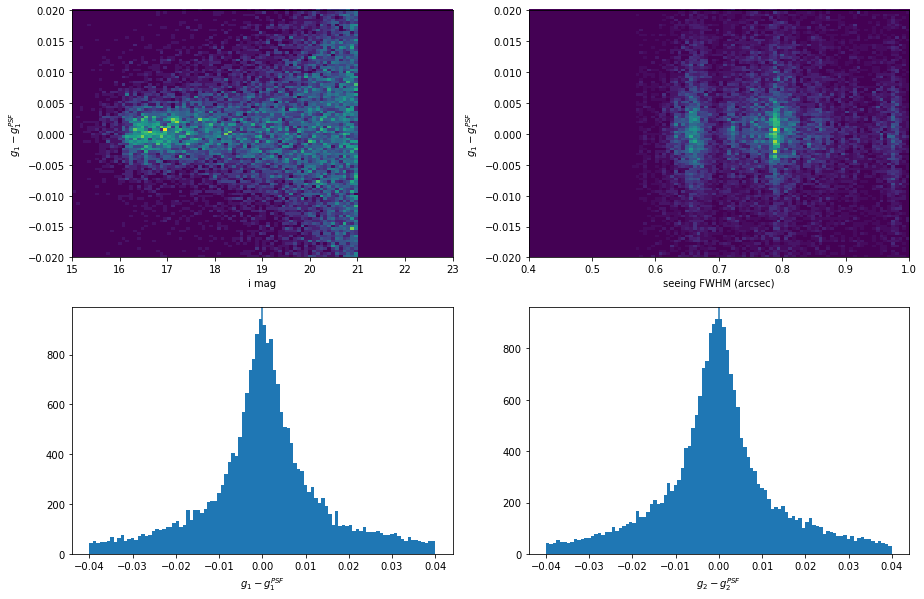

In [8]:
figure(figsize=(15,10))

subplot(221)
hist2d(data['mag_i'], (data['g1'] - data['psf_g1']), 100, range=[[15,23],[-0.02,0.02]]);
xlabel('i mag')
ylabel('$g_1 - g_1^{PSF}$')
subplot(222)
hist2d(data['psf_fwhm_i'], (data['g1'] - data['psf_g1']), 100, range=[[0.4,1.0],[-0.02,0.02]]);
xlabel('seeing FWHM (arcsec)')
ylabel('$g_1 - g_1^{PSF}$')

subplot(223)
hist((data['g1'] - data['psf_g1']), 100, range=[-0.04,0.04]);
xlabel('$g_1 - g_1^{PSF}$')
axvline(0)
subplot(224)
hist((data['g2'] - data['psf_g2']), 100, range=[-0.04,0.04]);
xlabel('$g_2 - g_2^{PSF}$')
axvline(0)

In [9]:
import pandas
import stile

d = pandas.DataFrame(data)
d['w'] =1
d = d.to_records(index=False)

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [10]:
stile_args = {'ra_units': 'degrees', 'dec_units': 'degrees',
              'min_sep': 0.05, 'max_sep': 1, 'sep_units': 'degrees', 'nbins': 20}

In [11]:
rho1 = stile.CorrelationFunctionSysTest('Rho1')
rho2 = stile.CorrelationFunctionSysTest('Rho2')

r1 = rho1(d, config=stile_args)
r2 = rho2(d, config=stile_args)

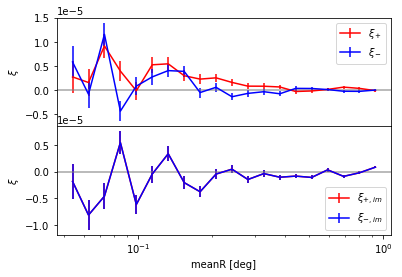

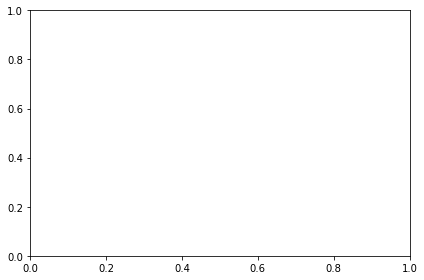

In [12]:
f = rho1.plot(r1);

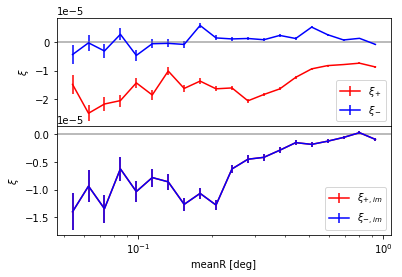

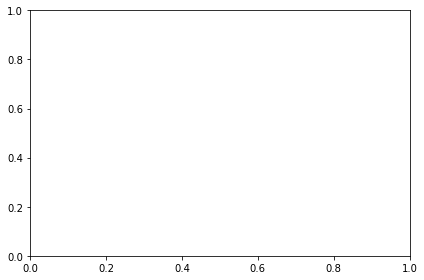

In [13]:
f = rho2.plot(r2);